<a href="https://colab.research.google.com/github/zzi8974/Python/blob/master/bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#############################################
# step 1 탐색
#############################################

시계열 데이터 : 연속적인 시간에 따라 측정되는 데이터, 분석 -> 시계열 데이터 분석

1) 규칙적 - 심장박동
2) 불규칙적 - 비트코인 



In [ ]:
%matplotlib inline

import pandas as pd #분석
import numpy as np  #계산
import matplotlib.pyplot as plt


bitcoin_df = pd.read_csv('market-price.csv', names = ['day','price'])


In [ ]:
print(bitcoin_df.shape)

(365, 2)


In [ ]:
print(bitcoin_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [ ]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


In [ ]:
# day 피처를 시계열 피처 변환
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

In [ ]:
print(bitcoin_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     365 non-null    datetime64[ns]
 1   price   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None


In [ ]:
# day 피처값을 인덱스로 설정
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)




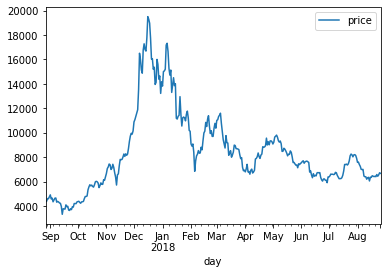

In [ ]:
# 시각화

bitcoin_df.plot()
plt.show()


In [ ]:
#############################################
# step 2 예측
#############################################

ARIMA 분석 방법  AR + I + MA

AR : 자기 자신의 과거 정보로 예측, 현재 상태는 이전의 상태를 참고해서 계산 될수있다.
MA : 이전의 오차 정보로 예측

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm 

In [ ]:
model = ARIMA(bitcoin_df.price.values, order=(2,1,2)) # 2 AR , 1 차분, 2 MA
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.074
Method:                       css-mle   S.D. of innovations            501.536
Date:                Wed, 07 Oct 2020   AIC                           5572.148
Time:                        03:04:56   BIC                           5595.531
Sample:                             1   HQIC                          5581.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3906     26.944      0.237      0.813     -46.419      59.200
ar.L1.D.y      0.4496      0.029     15.512      0.000       0.393       0.506
ar.L2.D.y     -0.9622      0.023    -42.314      0.0

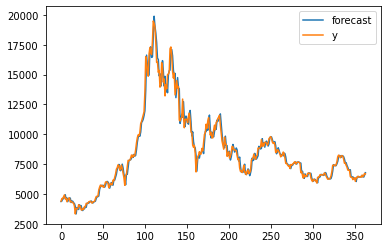

In [ ]:
fig = model_fit.plot_predict()

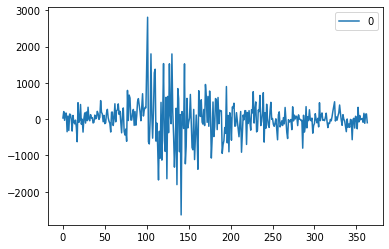

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
# 실제값과 예측값 사이의 오차 변동을 나타낸 그림
# 폭이 일정하면 좋은 예측 모델

In [ ]:
# 예측값을 실제 데이터와 비교

bitcoin_test_df = pd.read_csv('market-price-test.csv', names=['day','price'])

In [ ]:
# 학습데이터셋으로부터 5일 뒤를 예측
forecast_data = model_fit.forecast(steps=5)

#마지막 5일의 예측 데이터
pred_price = forecast_data[0].tolist()
test_price = bitcoin_test_df.price.values
pred_price_lower = [] # 마지막 5일의 예측 데이터의 최소값
pred_price_upper = [] # 마지막 5일의 예측 데이터의 최대값

for lower_upper in forecast_data[2]:
  lower = lower_upper[0]
  upper = lower_upper[1]
  pred_price_lower.append(lower)
  pred_price_upper.append(upper)



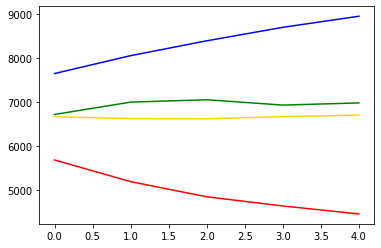

In [ ]:
plt.plot(pred_price, color="gold")        ## 예측한 가격
plt.plot(pred_price_lower, color="red")   # 하한가
plt.plot(pred_price_upper, color="blue")  # 상한가
plt.plot(test_price, color="green")       ## 실제 가격

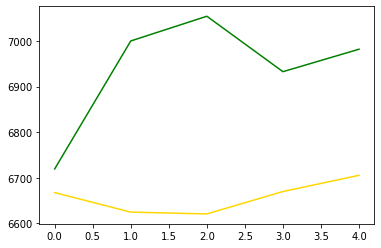

In [ ]:
plt.plot(pred_price, color="gold")        ## 예측한 가격
plt.plot(test_price, color="green")       ## 실제 가격

Facebook Prophet
  Additive 모델이라는 모델링 방법에 기반한 시계열 예측 모델
  시계열 데이터의 트렌드성(연간/월간/일간) 을 예측 

In [ ]:
pip install fbprophet

In [ ]:
from fbprophet import Prophet

In [ ]:
# 피처명 변경
# prophet input data columns 'ds','y' 고정

bitcoin_df = pd.read_csv('market-price.csv', names = ['ds','y'])
bitcoin_test_df = pd.read_csv('market-price-test.csv', names = ['ds','y'])

In [ ]:
prophet  = Prophet(seasonality_mode = 'multiplicative',
                   yearly_seasonality = True,
                   weekly_seasonality = True,
                   daily_seasonality = True,
                   changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)



In [ ]:
# 5일 앞을 내다보며 예측

future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

forecast_data.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,595.073916,6203.262028,7565.898760,595.073916,595.073916,10.907431,10.907431,10.907431,10.544862,10.544862,10.544862,-0.007796,-0.007796,-0.007796,-0.354773,-0.354773,-0.354773,0.0,0.0,0.0,6870.046369
366,2018-08-28,598.125014,6241.528294,7638.865894,598.125014,598.125014,10.907431,10.907431,10.907431,10.633309,10.633309,10.633309,0.026363,0.026363,0.026363,-0.300485,-0.300485,-0.300485,0.0,0.0,0.0,6958.173352
367,2018-08-29,601.176113,6305.899466,7650.969873,601.176113,601.176113,10.907431,10.907431,10.907431,10.588920,10.588920,10.588920,-0.055193,-0.055193,-0.055193,-0.263318,-0.263318,-0.263318,0.0,0.0,0.0,6966.981989
368,2018-08-30,604.227211,6302.098900,7798.230489,600.279312,607.195021,10.907431,10.907431,10.907431,10.631542,10.631542,10.631542,-0.029402,-0.029402,-0.029402,-0.246487,-0.246487,-0.246487,0.0,0.0,0.0,7028.094432
369,2018-08-31,607.278310,6338.167674,7931.822169,599.184737,619.878517,10.907431,10.907431,10.907431,10.694373,10.694373,10.694373,0.039476,0.039476,0.039476,-0.252535,-0.252535,-0.252535,0.0,0.0,0.0,7101.738804


In [ ]:
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6870.046369,6203.262028,7565.898760
366,2018-08-28,6958.173352,6241.528294,7638.865894
367,2018-08-29,6966.981989,6305.899466,7650.969873
368,2018-08-30,7028.094432,6302.098900,7798.230489
369,2018-08-31,7101.738804,6338.167674,7931.822169


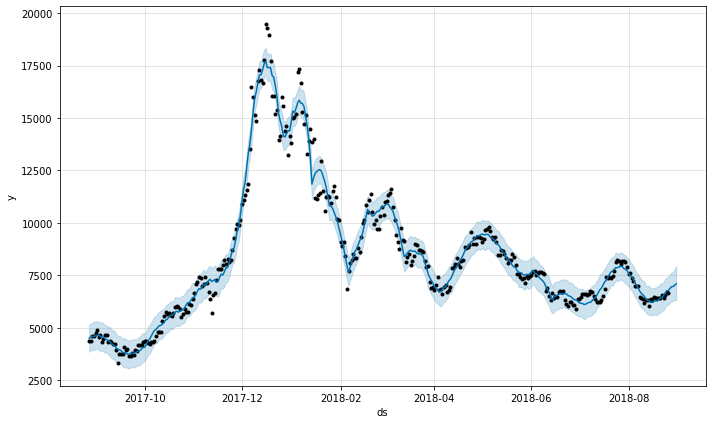

In [ ]:
fig1 = prophet.plot(forecast_data)

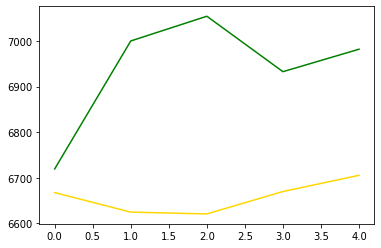

In [ ]:
plt.plot(pred_price, color="gold") # 예상
plt.plot(test_price, color="green") # 실제 가격데이터
